In [1]:
# Initialization boilerplate
from typing import *

from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import pandas as pd

import os
import json
import time
import threading

import ibm_watson
import ibm_watson.natural_language_understanding_v1 as nlu
import ibm_cloud_sdk_core

# Enable profiling
#os.environ["RAY_PROFILING"] = "1"

import ray
if not ray.is_initialized():
    ray.init()

import market_intelligence as mi
articles = mi.maybe_download_articles()
my_doc_html = articles["html"].iloc[0]

doc_htmls = list(articles["html"])

2021-06-22 09:02:30,091	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


In [2]:
articles

,url,html
0,https://newsroom.ibm.com/2020-02-04-The-Avril-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
1,https://newsroom.ibm.com/2020-02-11-IBM-X-Forc...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
2,https://newsroom.ibm.com/2020-02-18-IBM-Study-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
3,https://newsroom.ibm.com/2020-02-19-IBM-Power-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
4,https://newsroom.ibm.com/2020-02-20-Centotrent...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
...,...,...
186,https://newsroom.ibm.com/2021-01-25-OVHcloud-t...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
187,https://newsroom.ibm.com/2021-01-26-Luminor-Ba...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
188,https://newsroom.ibm.com/2021-01-26-DIA-Levera...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
189,https://newsroom.ibm.com/2021-01-26-IBM-Board-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."


# Part 4: How to Add Flow Control to Ray Applications

[Ray](https://ray.io) is an open source framework for building high-performance distributed applications. One of the distinguishing features of Ray is its support for task-based parallelism. A Ray application can launch many independent [*tasks*](https://docs.ray.io/en/master/walkthrough.html#remote-functions-tasks), each of which operates independently of the rest. 

The task-based model provides several benefits compared with more rigid  models like MapReduce. Tasks are particularly useful for interacting with systems that are outside your Ray application. For example:
* In Reinforcement Learning (RL) applications, Ray tasks can trigger actions in the real world, such as updating the list of suggested products for a user on your web site.
* In Extract-Transform-Load (ETL) applications, Ray tasks can stream small batches of updated records to a remote database.
* In AI inference applications, Ray tasks can send requests to AI models that run behind web service APIs; or they can send audit information to a remote service that tracks model drift.

This greater flexibility for interacting with the outside world comes a potential pitfall: *A Ray application can issue a very large number of remote requests in a very short amount of time.* Ray was designed [from the beginning](https://bair.berkeley.edu/blog/2018/01/09/ray/) to support running millions of tasks per second. If each of those tasks talks to a remote service, your application can have some serious unintended consequences. It could interfere with other users of the remote servie, or even bring down the service entirely. The service's security software could interpret your network traffic as an attack and block your application. Or a misbehaving Ray application could lead to a suprise cloud bill if your cloud provider charges you for each service call.

Fortunately, you can mitigate all of these risks by adding **flow control** to your Ray application. *Flow control* is a computer networking term that basically means, "ensuring that your rate of traffic stays within some well-defined bounds." Applying flow control to your application's interactions with a remote service means controlling things like the number of requests per second, the amount of data you send per second, or the amount of load that you are putting on the remote service.

In this article, we'll show you how to implement application-level flow control from inside a Ray application, using Ray's own parallel processing APIs.

## Tracking State with Ray Actors

In addition to tasks, Ray's parallelism model also includes the concept of *actors*. A Ray [actor](https://docs.ray.io/en/master/actors.html) is a Python or Java object that Ray tasks can interact with. Actors are useful for storing state that your application needs to share between multiple tasks. For example, you can use an actor to hold the current set of weights for a model that your application is training. Or the actor could hold the state of a simulator that your model is interacting with for reinforcement learning.

In addition to things like models and data, an actor's state can also store control information about the application itself. That's what we're going to do here: use an actor to store information about how quickly the application is currently hitting a remote serivce. 

All of this state-tracking functionality can go into a base class that you can reuse across multiple applications. Here's an example of such a base class, implemented in Python:

In [26]:
# Keep this cell in sync with the correspondng Github gist at
# https://gist.github.com/frreiss/d89a4cf9b26438eb75bbe9facb2c030a

class FlowControlledActorBase(ABC):
    """
    Abstract base class for actors that limit their request rate.
    """
    def __init__(self):
        self._sec_per_request = 0.0  # Start out with no flow control.
        self._last_request_time = time.time() - 1.0
        self._num_pending_requests = 0
        self._lock = threading.Lock()
        
    def set_rate_limit(self, requests_per_sec: float):
        """
        :param requests_per_sec: Upper limit on the number of requests per 
         second that the ``process`` method will allow, or -1 to remove the
         limit.
        """
        with self._lock:
            if requests_per_sec <= 0:
                # Disable flow control.
                self._sec_per_request = 0.0 
            else:
                self._sec_per_request = 1.0 / requests_per_sec
    
    def process(self, argument: Any) -> Any:
        # Basic rate-limiting logic
        with self._lock:
            self._num_pending_requests += 1
            time_since_request = time.time() - self._last_request_time
            required_delay = self._sec_per_request * self._num_pending_requests
            time_until_deadline = required_delay - time_since_request
            if time_until_deadline <= 0:
                # No delay; set last request time before releasing lock, in 
                # case there is another thread checking the time.
                self._last_request_time = time.time()
        if time_until_deadline > 0:
            time.sleep(time_until_deadline)
        with self._lock:    
            self._num_pending_requests -= 1
            self._last_request_time = time.time()
        return self.process_internal(argument)

    
    @abstractmethod
    def process_internal(self, argument: Any) -> Any:
        raise NotImplementedError("Subclasses must implement this method")

This class, `FlowControlledActorBase`, has four main parts. Let's go over them briefly.

The constructor, `__init__()`, sets up the object fields that will track the flow control state. In this example, the only information we are storing is the minimum time between requests, the timestamp of the most recent request, and the number of pending requests. We also create a lock object to allow different Ray tasks to share this state safely. If we wanted to, we could store more complex information here, such as a moving average of request latency or  bytes transmitted per second. Use whatever information is appropriate for your application's flow control logic.

The second part of the the `FlowControlledActorBase` class is the method `set_rate_limit()`. This method lets the application adjust the maximum number of requests per second that the actor will allow.

The third part of class is the `process()` method. This method is where the rate-limiting logic lives. When a Ray task enters the `process()` method, it checks whether enough time has elapsed since the most recent request. If it's too soon to issue another request, the task calculates how long it should wait, waits that amount of time, and then issues the request. Multiple tasks can be inside `process()` at the same time, so we also include some locking to keep everything thread-safe.

The last part of the class is an abstract method `process_internal()`. Subclasses of `RateLimitedActor` can override `process_internal()` with appropriate code to call the remote service.

# Defining your Actor

Once you've defined a base class like `FlowControlledActorBase`, you can use that base class to create a Ray actor that talks to a remote service in a controlled way. Here is some example code that creates such an actor for talking to the [IBM Watson Natural Language Understanding](https://www.ibm.com/cloud/watson-natural-language-understanding?cm_mmc=text_extensions_for_pandas) web service.

In [27]:
# Keep this cell in sync with https://gist.github.com/frreiss/9a6d652942e9091f218355ed88f5c5c3

# Define some constants that tell how to access Watson Natural Language Understanding
API_KEY = os.environ.get("STANDARD_API_KEY")
SERVICE_URL = os.environ.get("STANDARD_SERVICE_URL")  
FEATURES = nlu.Features(entities=nlu.EntitiesOptions(mentions=True))

@ray.remote
class FlowControlledActor(FlowControlledActorBase):
    def process_internal(self, argument: Any) -> Any:
        nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(API_KEY))
        nlu_api.set_service_url(SERVICE_URL)
        return nlu_api.analyze(html=argument, features=FEATURES).get_result()

The [`@ray.remote` decorator](https://docs.ray.io/en/master/actors.html#creating-an-actor)
attached to the definition of the `FlowControlledActor` tells Ray to turn this class into a factory object for creating Ray actors. 

The `FlowControlledActor` class implements the `process_internal()` method from its parent class. This `process_internal()` method opens a connection to Watson Natural Language Understanding, sends a request, and returns the service's response.

It's important to note that the Python client library for Watson Natural Language Understanding is thread-safe and non-blocking. Multiple Python threads can be inside the Natural Language Understanding `analyze()` API call at the same time without interfering with each other. If the client for your remote service does not have these properties, you will want to use a Ray task to isolate each service call in its own process. Here's what the code above looks like if we ran each call to Watson Natural Language Understanding in a separate Ray task.

In [28]:
# Keep this cell in sync with https://gist.github.com/frreiss/4475dea0ca9bc2d0bd21272f063e19a5

@ray.remote
def call_nlu_task(argument: Any) -> Any:
    """Ray task to make a single call to Watson Natural Language Understanding"""
    nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
        authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(API_KEY))
    nlu_api.set_service_url(SERVICE_URL)
    return nlu_api.analyze(html=argument, features=FEATURES).get_result()

@ray.remote
class FlowControlledActor2(FlowControlledActorBase):    
    def process_internal(self, argument: Any) -> Any:
        # Spawn a Ray task to handle the request and block the calling thread
        # until the result returns.
        return ray.get(call_nlu_task.remote(argument))
        

Regardless of whether you use a thread-safe client or a pool of tasks to talk to the remote service, the code to use actor looks the same. Here is some Python code that creates a `FlowControlledActor` actor and routes a single request through it.

In [29]:
# Keep this cell in sync with https://gist.github.com/frreiss/3741ac826259238799316b92cdf644cd

# Create a Ray actor that will limit requests to Watson Natural Language
# Understanding in two ways:
# * No more than 5 requests per second
# * No more than 10 simultaneous requests
nlu_client_actor = FlowControlledActor.options(max_concurrency=10).remote()
ray.get(nlu_client_actor.set_rate_limit.remote(5.0))

# Example of passing a document to the actor. This action spawns an 
# asynchronous Ray task that will wait an appropriate amount of time, 
# then send a request to Watson Natural Language Understanding.
result_ref = nlu_client_actor.process.remote(my_doc_html)

# Wait for the task to complete and retrieve its result.
doc_results = ray.get(result_ref)


In [30]:
# Don't include this cell in the blog version.
# Display the first few lines of the output of the previous cell to ensure it works.
doc_results_str = json.dumps(doc_results, indent=2)
print("\n".join(doc_results_str.splitlines()[:15]) + "\n[...]")

{
  "usage": {
    "text_units": 1,
    "text_characters": 4940,
    "features": 1
  },
  "language": "en",
  "entities": [
    {
      "type": "Organization",
      "text": "Avril Group",
      "relevance": 0.951111,
      "mentions": [
        {
          "text": "Avril Group",
[...]


Let's walk through these four lines of Python one at a time.

The first line creates a Ray actor. Remember that the `@ray.remote` decorator on the `FlowControlledActor` class turned that class into a factory for Ray actors. Ray's factory objects use [method chaining](https://en.wikipedia.org/wiki/Method_chaining) to pass parameters. So the code here:
```python
nlu_client_actor = FlowControlledActor.options(max_concurrency=10).remote()
```
tells Ray to create an actor and to set its `max_concurrency` parameter to 10. `max_concurrency` is a Ray parameter that controls how many Ray tasks can use the actor at the same time. If more than this number of tasks try to use the actor, Ray will queue the excess tasks until the actor becomes available.

The second line:
```python
ray.get(nlu_client_actor.set_rate_limit.remote(5.0))
```
calls the `set_rate_limit()` method we defined earlier in the `RateLimitedActor` base class. This line uses `ray.get()` to block the calling process until the actor has put the new policy into place.

Taken together, these two lines of code apply two kinds of flow control to our application's requests to Watson Natural Language Understanding:
* No more than 5 requests per second.
* No more than 10 simultaneous requests.

The third line shows how to spawn a background task to send a single request to Watson Natural Language Understanding:
```python
result_ref = nlu_client_actor.process.remote(my_doc_html)
```

The return value from this line is a Ray *object reference* --- a handle that our application can use to access the task's return value once the task has completed. The fourth line of code uses the `ray.get()` function to block until the task has completed:
```python
doc_results = ray.get(result_ref)
```

## Flow Control in Action

Here's a quick microbenchmark that demonstrates flow control in action.

In [32]:
# Keep this cell in sync with https://gist.github.com/frreiss/5d8271b99e361857c31dd417fd1ea6ef

# Define some constants. `doc_htmls` is a list of large HTML documents.
doc_iter = iter(doc_htmls)
burst_size = 10
num_bursts = 3
sec_between_bursts = 2

# Start up an actor that will apply flow control to our requests to.
nlu_client_actor = FlowControlledActor.options(max_concurrency=10).remote()
ray.get(nlu_client_actor.set_rate_limit.remote(5.0))

# Send bursts of documents to the flow control actor.
result_refs_list = []
for b in range(num_bursts):
    for i in range(burst_size):
        result_refs_list.append(nlu_client_actor.process.remote(next(doc_iter)))
        time.sleep(0.001)
    time.sleep(sec_between_bursts)

# Wait until all the remote requests are done and fetch the results
# from Plasma object storage.
all_results_list = ray.get(result_refs_list)

In [33]:
# Don't include this cell in the blog version.
# Display the first few lines of the output to ensure everything went OK.
all_results_str = json.dumps(all_results_list, indent=2)
print("\n".join(all_results_str.splitlines()[:20]) + "\n[...]")

[
  {
    "usage": {
      "text_units": 1,
      "text_characters": 4940,
      "features": 1
    },
    "language": "en",
    "entities": [
      {
        "type": "Organization",
        "text": "Avril Group",
        "relevance": 0.951111,
        "mentions": [
          {
            "text": "Avril Group",
            "location": [
              48,
              59
            ],
[...]


This microbenchmark produces a "burst" of 10 large HTML documents every 2 seconds. It sends the documents to Watson Natural Language Understanding for processing, using the flow control actor to limit the request rate to 5 requests per second.

The plot below shows a timeline of the first 7 seconds of this microbenchmark. Each horizontal bar represents the processing for a single document. The part of the bar in blue shows time that the document spent queued due to flow control. The orange part shows the time that the document spent being processed by Watson Natural Language Understanding.

In [34]:
# Don't include this cell in the blog.
if ray.is_initialized():
    ray.shutdown()
ray.init()

2021-06-22 09:17:34,202	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.238',
 'raylet_ip_address': '192.168.0.238',
 'redis_address': '192.168.0.238:6379',
 'object_store_address': '/tmp/ray/session_2021-06-22_09-17-33_758017_2137/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-22_09-17-33_758017_2137/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-06-22_09-17-33_758017_2137',
 'metrics_export_port': 64229,
 'node_id': '4e6edc7ad94b378395d3a986f17707c6cf326f21f6881c0640a71d18'}

In [35]:
# Don't include this cell in the blog.

# Version of the code above with some application-level tracing.

@ray.remote
class TraceActor:
    def __init__(self):
        self._events = []
        
    def log_event(self, event: Dict):
        self._events.append(event)
        
    def get_events(self) -> pd.DataFrame:
        return pd.DataFrame.from_records(self._events)
    
def make_event(doc_id, event_type):
    return  {
        "doc_id": doc_id,
        "event": event_type,
        "sec": time.time()
    }

@ray.remote
class NLUClientActor2(FlowControlledActorBase):
    """
    FlowControlledActor with some application-level tracing.
    """
    def __init__(self, trace: TraceActor):
        super().__init__()
        self._trace = trace
        
    def process2(self, argument: Any) -> Any:
        self._trace.log_event.remote(make_event(argument["doc_id"], "process2"))
        return self.process(argument)
              
    def process_internal(self, argument: Any) -> Any:
        self._trace.log_event.remote(make_event(argument["doc_id"], "start"))
        nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(API_KEY))
        nlu_api.set_service_url(SERVICE_URL)
        result = nlu_api.analyze(html=argument["doc_html"], features=FEATURES).get_result()
        self._trace.log_event.remote(make_event(argument["doc_id"], "finish"))
        return result
    
# Create an actor with application-level logging
trace_actor = TraceActor.remote()
nlu_client_actor_2 = NLUClientActor2.options(max_concurrency=10).remote(trace_actor)
ray.get(nlu_client_actor_2.set_rate_limit.remote(5.0))

# Pass documents to Watson Natural Language Understanding in bursts.
# nlu_client_actor will apply flow control to the resulting requests.
result_refs_list = []

burst_size = 10
num_bursts = 3
sec_between_bursts = 2

doc_id = 1  # Start at 1 so that graph looks prettier
for b in range(num_bursts):
    for i in range(burst_size):
        trace_actor.log_event.remote(make_event(doc_id, "enqueue"))
        object_ref = nlu_client_actor_2.process2.remote(
            {"doc_id": doc_id, "doc_html": doc_htmls[doc_id]}
        )
        result_refs_list.append(object_ref)
        doc_id += 1
        time.sleep(0.001)
    time.sleep(sec_between_bursts)


# Wait until all the remote requests are done
all_results_list = ray.get(result_refs_list)

In [36]:
# Do not include this cell in the blog

# Fetch our application-level trace
df = ray.get(trace_actor.get_events.remote())
min_sec = df["sec"].min()
df["elapsed"] = df["sec"] - min_sec
df.iloc[:20]

,doc_id,event,sec,elapsed
0,1,enqueue,1.624379e+09,0.000000
1,2,enqueue,1.624379e+09,0.001522
2,1,process2,1.624379e+09,0.001114
3,1,start,1.624379e+09,0.001335
4,2,process2,1.624379e+09,0.002645
5,3,enqueue,1.624379e+09,0.002851
6,3,process2,1.624379e+09,0.003636
7,4,enqueue,1.624379e+09,0.004484
8,4,process2,1.624379e+09,0.005180
9,5,enqueue,1.624379e+09,0.005735


In [37]:
# Do not include this cell in the blog

# Pivot the trace dataframe into a dataframe of document metrics
event_slices = [
    (
        df[df["event"] == e]
        [["doc_id", "elapsed"]]
        .rename(columns={"elapsed": e})
    ) for e in df["event"].unique()]

metrics = event_slices[0]
for i in range(1, len(event_slices)):
    metrics = metrics.merge(event_slices[i])
metrics

,doc_id,enqueue,process2,start,finish
0,1,0.000000,0.001114,0.001335,0.839372
1,2,0.001522,0.002645,0.204149,1.293197
2,3,0.002851,0.003636,0.401851,0.964305
3,4,0.004484,0.005180,0.604314,1.253000
4,5,0.005735,0.006341,0.801710,1.965402
5,6,0.007124,0.007859,1.002118,1.733160
6,7,0.008610,0.009241,1.202433,1.994589
7,8,0.009942,0.010707,1.402767,2.270194
8,9,0.011198,0.011856,1.605903,2.526879
9,10,0.012702,0.013337,1.802209,3.945643


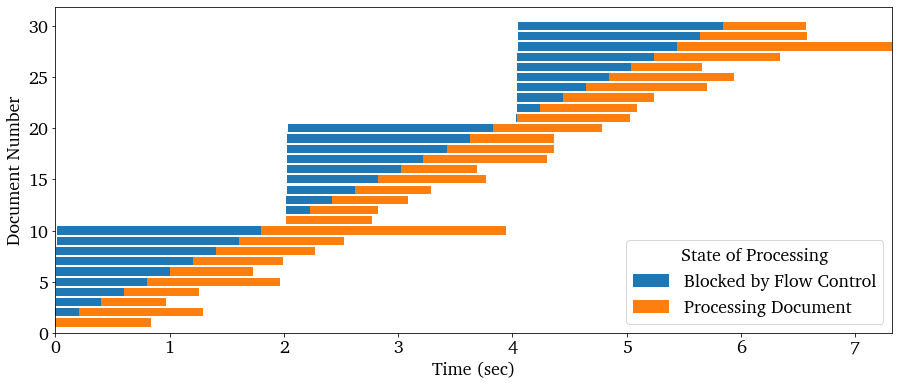

In [40]:
# Do not include this cell in the blog
# Verify that the flow control is working by graphing the timeline

step_names = ("enqueue", "start", "finish")
interval_names = ("Blocked by Flow Control", "Processing Document")

# font = {'family' : 'arial',
#         'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# Match the Medium font
plt.rcParams.update({"font.family": "Charter"})
plt.rcParams.update({"font.size": 18})

# Generate a pretty plot of the metrics
plt.figure(figsize=(15, 6))
if len(metrics.index) > 0:
    for step_num in range(1, len(step_names)):
        this_step = step_names[step_num]
        prev_step = step_names[step_num - 1]
        this_interval = interval_names[step_num - 1]
#         plt.bar(
#             metrics["doc_id"], 
#             metrics[this_step] - metrics[prev_step], 
#             bottom=metrics[prev_step],
#                label=this_step)
        plt.barh(
            metrics["doc_id"], 
            metrics[this_step] - metrics[prev_step], 
            left=metrics[prev_step],
            label=this_interval)
    plt.legend(loc="lower right", title="State of Processing")

#plt.xlabel("Document ID")
#plt.ylabel("time")
plt.xlabel("Time (sec)")
plt.ylabel("Document Number")
plt.ylim(bottom=0)
plt.xlim(0, metrics[step_names[-1]].max())

plt.show()

You can see how the flow control smooths out each "burst" of ten documents into a steady, predictable stream of requests.

We hope that you've enjoyed this introduction to using Ray Actors to add flow control to Ray applications. If you'd like to try out Ray at scale, take at look at [this post](https://www.ibm.com/cloud/blog/ray-on-ibm-cloud-code-engine?cm_mmc=text_extensions_for_pandas) on how to use Ray with [IBM Cloud Code Engine](https://www.ibm.com/cloud/code-engine?cm_mmc=text_extensions_for_pandas).
